## Imports and Setup

In [ ]:
import torch
import skimage
import numpy as np
import matplotlib.pyplot as plt
import argparse
import PIL
import pandas as pd
import cv2
from torch.nn import Module
from torch.nn import Conv2d
from torch.nn import Linear
from torch.nn import MaxPool2d
from torch.nn import ReLU
from torch.nn import LogSoftmax
from torch import flatten

import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from tqdm import tqdm

from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from torch.utils.data import random_split
from torch.utils.data import DataLoader
import torchvision.transforms as T
from torchvision.transforms import ToTensor
from torchvision.datasets import KMNIST
from torch.optim import Adam
from torch import nn

import argparse
import torch
import time

In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
%cd /content/drive/MyDrive/cs283-data/tiny-imagenet-200/test

Mounted at /content/drive
/content/drive/MyDrive/cs283-data/tiny-imagenet-200/test


## Load Data from Directory
### Additional Imports

In [ ]:
a = []
l = []
g = []
m = 0
for filename in os.listdir("./images"):
    f = os.path.join("./images", filename)
    # checking if it is a file
    if os.path.isfile(f) and m < 1000:
        im = cv2.imread(f)
        a.append(im)
        l.append(cv2.cvtColor(im, cv2.COLOR_BGR2Lab))
        g.append(cv2.cvtColor(im, cv2.COLOR_BGR2GRAY))
        m += 1

In [ ]:
l = np.stack(l)
g = np.stack(g)

X_train, X_test, y_train, y_test = train_test_split(l[:, :, :, 0], l, test_size=0.33, random_state=42)

In [ ]:
X_train.shape

(670, 64, 64)

In [ ]:
# Create color map quantizations

# TODO: later, add this functionality, that quantizes the bins and then

## Define Custom Dataset Class and Loss Function

In [ ]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, x, y):
        super(MyDataset, self).__init__()
        self.X = x
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        image = self.X[index]
        label = self.y[index]
        X = self.transform(image)
        y = self.transform(label)
        return X, y

    transform = T.Compose([
        T.ToTensor()])

In [ ]:
# define training hyperparameters
INIT_LR = 1e-3
BATCH_SIZE = 64
EPOCHS = 10
# define the train and val splits
TRAIN_SPLIT = 0.75
VAL_SPLIT = 1 - TRAIN_SPLIT
# set the device we will be using to train the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Load images with DataLoader
BATCH_SIZE = 64
trainData = MyDataset(X_train, y_train[:, :, :, 1:])
valData = MyDataset(X_test, y_test[:, :, :, 1:])

In [ ]:
# initialize the train, validation, and test data loaders
trainDataLoader = DataLoader(trainData, shuffle=True,
	batch_size=BATCH_SIZE)
valDataLoader = DataLoader(valData, batch_size=BATCH_SIZE)
# testDataLoader = DataLoader(testData, batch_size=BATCH_SIZE)
# calculate steps per epoch for training and validation set
trainSteps = len(trainDataLoader.dataset) // BATCH_SIZE
valSteps = len(valDataLoader.dataset) // BATCH_SIZE

In [ ]:
from torchvision.utils import make_grid
from torchvision.utils import save_image

def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid((images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, labels in dl:
        show_images(images, nmax)
        break

In [ ]:
data = trainDataLoader.dataset.X
shape = trainDataLoader.dataset.X.shape
datatype = trainDataLoader.dataset.X.dtype


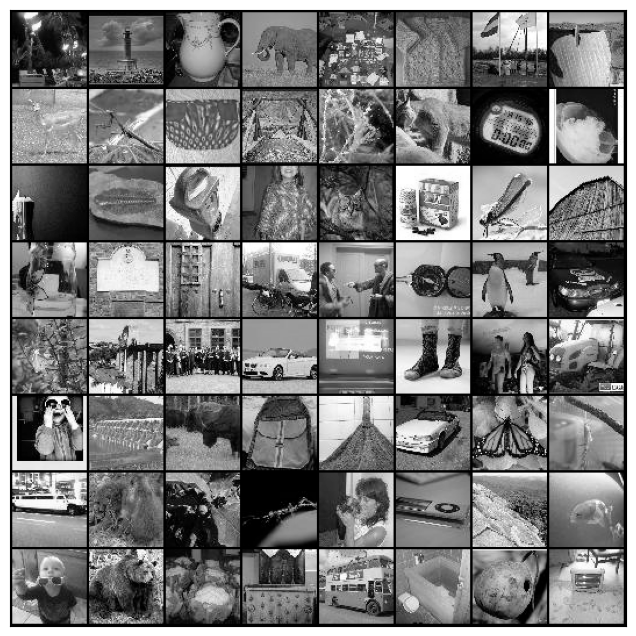

In [ ]:
show_batch(valDataLoader)
plt.show()

In [ ]:
# @title
class ColorCNN(nn.Module):
    def __init__(self):
        super(ColorCNN, self).__init__()

        self.trecip = nn.Parameter(torch.Tensor(1, 313, 16, 16))

        # *****************
        # ***** conv1 *****
        # *****************
        self.conv1_1 = nn.Conv2d(2, 64, kernel_size=3, padding=1)
        self.relu1_1 = nn.ReLU(inplace=True)
        self.conv1_2 = nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1)
        self.relu1_2 = nn.ReLU(inplace=True)
        self.conv1_2norm = nn.BatchNorm2d(64)

        # *****************
        # ***** conv2 *****
        # *****************
        self.conv2_1 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.relu2_1 = nn.ReLU(inplace=True)
        self.conv2_2 = nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=1)
        self.relu2_2 = nn.ReLU(inplace=True)
        self.conv2_2norm = nn.BatchNorm2d(128)

        # *****************
        # ***** conv3 *****
        # *****************
        self.conv3_1 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.relu3_1 = nn.ReLU(inplace=True)
        self.conv3_2 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.relu3_2 = nn.ReLU(inplace=True)
        self.conv3_3 = nn.Conv2d(256, 256, kernel_size=3, stride=2, padding=1)
        self.relu3_3 = nn.ReLU(inplace=True)
        self.conv3_3norm = nn.BatchNorm2d(256)

        # *****************
        # ***** conv4 *****
        # *****************
        self.conv4_1 = nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1, dilation=1)
        self.relu4_1 = nn.ReLU(inplace=True)
        self.conv4_2 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, dilation=1)
        self.relu4_2 = nn.ReLU(inplace=True)
        self.conv4_3 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, dilation=1)
        self.relu4_3 = nn.ReLU(inplace=True)
        self.conv4_3norm = nn.BatchNorm2d(512)

        # *****************
        # ***** conv5 *****
        # *****************
        self.conv5_1 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=2, dilation=2)
        self.relu5_1 = nn.ReLU(inplace=True)
        self.conv5_2 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=2, dilation=2)
        self.relu5_2 = nn.ReLU(inplace=True)
        self.conv5_3 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=2, dilation=2)
        self.relu5_3 = nn.ReLU(inplace=True)
        self.conv5_3norm = nn.BatchNorm2d(512)

        # *****************
        # ***** conv6 *****
        # *****************
        self.conv6_1 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=2, dilation=2)
        self.relu6_1 = nn.ReLU(inplace=True)
        self.conv6_2 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=2, dilation=2)
        self.relu6_2 = nn.ReLU(inplace=True)
        self.conv6_3 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=2, dilation=2)
        self.relu6_3 = nn.ReLU(inplace=True)
        self.conv6_3norm = nn.BatchNorm2d(512)

        # *****************
        # ***** conv7 *****
        # *****************
        self.conv7_1 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, dilation=1)
        self.relu7_1 = nn.ReLU(inplace=True)
        self.conv7_2 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, dilation=1)
        self.relu7_2 = nn.ReLU(inplace=True)
        self.conv7_3 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, dilation=1)
        self.relu7_3 = nn.ReLU(inplace=True)
        self.conv7_3norm = nn.BatchNorm2d(512)

        # *****************
        # ***** conv8 *****
        # *****************
        self.conv8_1 = nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, dilation=1)
        self.relu8_1 = nn.ReLU(inplace=True)
        self.conv8_2 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, dilation=1)
        self.relu8_2 = nn.ReLU(inplace=True)
        self.conv8_3 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, dilation=1)
        self.relu8_3 = nn.ReLU(inplace=True)

        # *******************
        # ***** Softmax *****
        # *******************
        self.conv8_313 = nn.Conv2d(256, 313, kernel_size=1, stride=1, dilation=1)
        self.conv8_313_rh = nn.ReLU()
        self.class8_313_rh = nn.Softmax(dim=1)

        # ********************
        # ***** Decoding *****
        # ********************
        self.class8_ab = nn.Conv2d(313, 2, kernel_size=1, stride=1, dilation=1)

    def forward(self, data_l):
        # *****************
        # ***** conv1 *****
        # *****************
        conv1_1 = self.conv1_1(data_l)
        relu1_1 = self.relu1_1(conv1_1)
        conv1_2 = self.conv1_2(relu1_1)
        relu1_2 = self.relu1_2(conv1_2)
        conv1_2norm = self.conv1_2norm(relu1_2)

        # *****************
        # ***** conv2 *****
        # *****************
        conv2_1 = self.conv2_1(conv1_2norm)
        relu2_1 = self.relu2_1(conv2_1)
        conv2_2 = self.conv2_2(relu2_1)
        relu2_2 = self.relu2_2(conv2_2)
        conv2_2norm = self.conv2_2norm(relu2_2)

        # *****************
        # ***** conv3 *****
        # *****************
        conv3_1 = self.conv3_1(conv2_2norm)
        relu3_1 = self.relu3_1(conv3_1)
        conv3_2 = self.conv3_2(relu3_1)
        relu3_2 = self.relu3_2(conv3_2)
        conv3_3 = self.conv3_3(relu3_2)
        relu3_3 = self.relu3_3(conv3_3)
        conv3_3norm = self.conv3_3norm(relu3_3)

        # *****************
        # ***** conv4 *****
        # *****************
        conv4_1 = self.conv4_1(conv3_3norm)
        relu4_1 = self.relu4_1(conv4_1)
        conv4_2 = self.conv4_2(relu4_1)
        relu4_2 = self.relu4_2(conv4_2)
        conv4_3 = self.conv4_3(relu4_2)
        relu4_3 = self.relu4_3(conv4_3)
        conv4_3norm = self.conv4_3norm(relu4_3)

        # *****************
        # ***** conv5 *****
        # *****************
        conv5_1 = self.conv5_1(conv4_3norm)
        relu5_1 = self.relu5_1(conv5_1)
        conv5_2 = self.conv5_2(relu5_1)
        relu5_2 = self.relu5_2(conv5_2)
        conv5_3 = self.conv5_3(relu5_2)
        relu5_3 = self.relu5_3(conv5_3)
        conv5_3norm = self.conv5_3norm(relu5_3)

        # *****************
        # ***** conv6 *****
        # *****************
        conv6_1 = self.conv6_1(conv5_3norm)
        relu6_1 = self.relu6_1(conv6_1)
        conv6_2 = self.conv6_2(relu6_1)
        relu6_2 = self.relu6_2(conv6_2)
        conv6_3 = self.conv6_3(relu6_2)
        relu6_3 = self.relu6_3(conv6_3)
        conv6_3norm = self.conv6_3norm(relu6_3)

        # *****************
        # ***** conv7 *****
        # *****************
        conv7_1 = self.conv7_1(conv6_3norm)
        relu7_1 = self.relu7_1(conv7_1)
        conv7_2 = self.conv7_2(relu7_1)
        relu7_2 = self.relu7_2(conv7_2)
        conv7_3 = self.conv7_3(relu7_2)
        relu7_3 = self.relu7_3(conv7_3)
        conv7_3norm = self.conv7_3norm(relu7_3)

        # *****************
        # ***** conv8 *****
        # *****************
        conv8_1 = self.conv8_1(conv7_3norm)
        relu8_1 = self.relu8_1(conv8_1)
        conv8_2 = self.conv8_2(relu8_1)
        relu8_2 = self.relu8_2(conv8_2)
        conv8_3 = self.conv8_3(relu8_2)
        relu8_3 = self.relu8_3(conv8_3)

        # *******************
        # ***** Softmax *****
        # *******************
        conv8_313 = self.conv8_313(relu8_3)
        conv8_313_rh = self.conv8_313_rh(conv8_313 + self.trecip)
        class8_313_rh = self.class8_313_rh(conv8_313_rh)

        # ********************
        # ***** Decoding *****
        # ********************
        class8_ab = self.class8_ab(class8_313_rh)

        return class8_ab

In [207]:
def rarity_helper(color):
    # color is a two-channel color image:
    with torch.no_grad():
      # print(torch.mean(color)) # 0.5
      #print((np.hstack(((color[:, 1:2, :, :] - 0.5)**4, (color[:, 0:1, :, :] - 0.5)**4))).shape)

      rarity = ((np.hstack(((color[:, 1:2, :, :] - 0.5)**4, (color[:, 0:1, :, :] - 0.5)**4))) * 16) * 255
      # print(rarity.shape)
      return torch.from_numpy(rarity.astype(np.uint8))

def custom_loss(output, target):

    # Basic Euclidean Loss When Passed Color Space:
    # loss = torch.mean((output - target)**2)
    # return loss

    # Improved Loss by Weighting on Pixel Rarity/Vividity, or if a*, b*
    # print(output.shape, target.shape)
    a = rarity_helper(target)
    # print(a.shape)
    loss = torch.mean((output - target)**2 * a)

    return loss

In [208]:
# Set maximum parameters explicitly
input_channels = 1  # Grayscale images
output_classes = 10  # Number of classes in KMNIST
image_size = 64

class ColorCNN(nn.Module):
    def __init__(self):
        super(ColorCNN, self).__init__()

        # Encoder (downsampling)
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(64),

            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(128),

            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(256),


        )

        # Decoder (upsampling)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(128),

            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(64),

            nn.Conv2d(64, 2, kernel_size=1),  # Output has 2 channels (ab channels)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Set batch size
batch_size = 64

# Create an instance of the model
model = ColorCNN()

# Set maximum training parameters explicitly
learning_rate = 0.05
num_epochs = 5

# Define the loss function and optimizer
# criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in tqdm(trainDataLoader, desc=f'Epoch {epoch + 1}/{num_epochs}', leave=False):
        optimizer.zero_grad()
        outputs = model(images)
        loss = custom_loss(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f'Training Loss: {running_loss / len(trainDataLoader)}')

# Evaluation
model.eval()
correct = 0

with torch.no_grad():
    for images, labels in tqdm(valDataLoader, desc='Evaluating', leave=False):
        outputs = model(images)
        print(outputs.shape)
        print(labels.shape)
        correct += custom_loss(outputs, labels).sum()

accuracy = correct
print(f'Accuracy on the test set: {accuracy * 100:.2f}%')

Epoch 1/5:   0%|          | 0/11 [00:00<?, ?it/s]

(64, 2, 64, 64)


Epoch 1/5:   9%|▉         | 1/11 [00:08<01:25,  8.59s/it]

(64, 2, 64, 64)


Epoch 1/5:  18%|█▊        | 2/11 [00:16<01:11,  7.91s/it]

(64, 2, 64, 64)


Epoch 1/5:  27%|██▋       | 3/11 [00:25<01:07,  8.40s/it]

(64, 2, 64, 64)


Epoch 1/5:  36%|███▋      | 4/11 [00:33<00:58,  8.29s/it]

(64, 2, 64, 64)


Epoch 1/5:  45%|████▌     | 5/11 [00:42<00:51,  8.59s/it]

(64, 2, 64, 64)


Epoch 1/5:  55%|█████▍    | 6/11 [00:52<00:45,  9.15s/it]

(64, 2, 64, 64)


Epoch 1/5:  64%|██████▎   | 7/11 [01:01<00:35,  8.94s/it]

(64, 2, 64, 64)


Epoch 1/5:  73%|███████▎  | 8/11 [01:08<00:25,  8.46s/it]

(64, 2, 64, 64)


Epoch 1/5:  82%|████████▏ | 9/11 [01:16<00:16,  8.37s/it]

(64, 2, 64, 64)


Epoch 1/5:  91%|█████████ | 10/11 [01:24<00:08,  8.32s/it]

(30, 2, 64, 64)


Training Loss: 1.0328329307111828


Epoch 2/5:   0%|          | 0/11 [00:00<?, ?it/s]

(64, 2, 64, 64)


Epoch 2/5:   9%|▉         | 1/11 [00:08<01:21,  8.11s/it]

(64, 2, 64, 64)


Epoch 2/5:  18%|█▊        | 2/11 [00:15<01:10,  7.82s/it]

(64, 2, 64, 64)


Epoch 2/5:  27%|██▋       | 3/11 [00:24<01:04,  8.09s/it]

(64, 2, 64, 64)


Epoch 2/5:  36%|███▋      | 4/11 [00:32<00:56,  8.05s/it]

(64, 2, 64, 64)


Epoch 2/5:  45%|████▌     | 5/11 [00:40<00:48,  8.01s/it]

(64, 2, 64, 64)


Epoch 2/5:  55%|█████▍    | 6/11 [00:48<00:40,  8.12s/it]

(64, 2, 64, 64)


Epoch 2/5:  64%|██████▎   | 7/11 [00:56<00:32,  8.07s/it]

(64, 2, 64, 64)


Epoch 2/5:  73%|███████▎  | 8/11 [01:04<00:24,  8.23s/it]

(64, 2, 64, 64)


Epoch 2/5:  82%|████████▏ | 9/11 [01:13<00:16,  8.26s/it]

(64, 2, 64, 64)


Epoch 2/5:  91%|█████████ | 10/11 [01:20<00:08,  8.08s/it]

(30, 2, 64, 64)


Training Loss: 0.09186138060282577


Epoch 3/5:   0%|          | 0/11 [00:00<?, ?it/s]

(64, 2, 64, 64)


Epoch 3/5:   9%|▉         | 1/11 [00:07<01:13,  7.31s/it]

(64, 2, 64, 64)


Epoch 3/5:  18%|█▊        | 2/11 [00:15<01:09,  7.75s/it]

(64, 2, 64, 64)


Epoch 3/5:  27%|██▋       | 3/11 [00:23<01:03,  7.96s/it]

(64, 2, 64, 64)


Epoch 3/5:  36%|███▋      | 4/11 [00:31<00:54,  7.79s/it]

(64, 2, 64, 64)


Epoch 3/5:  45%|████▌     | 5/11 [00:39<00:47,  7.87s/it]

(64, 2, 64, 64)


Epoch 3/5:  55%|█████▍    | 6/11 [00:47<00:39,  7.93s/it]

(64, 2, 64, 64)


Epoch 3/5:  64%|██████▎   | 7/11 [00:54<00:31,  7.86s/it]

(64, 2, 64, 64)


Epoch 3/5:  73%|███████▎  | 8/11 [01:03<00:24,  8.01s/it]

(64, 2, 64, 64)


Epoch 3/5:  82%|████████▏ | 9/11 [01:10<00:15,  7.92s/it]

(64, 2, 64, 64)


Epoch 3/5:  91%|█████████ | 10/11 [01:19<00:07,  7.97s/it]

(30, 2, 64, 64)


Training Loss: 0.011375395665791902


Epoch 4/5:   0%|          | 0/11 [00:00<?, ?it/s]

(64, 2, 64, 64)


Epoch 4/5:   9%|▉         | 1/11 [00:08<01:20,  8.06s/it]

(64, 2, 64, 64)


Epoch 4/5:  18%|█▊        | 2/11 [00:16<01:14,  8.24s/it]

(64, 2, 64, 64)


Epoch 4/5:  27%|██▋       | 3/11 [00:23<01:03,  7.92s/it]

(64, 2, 64, 64)


Epoch 4/5:  36%|███▋      | 4/11 [00:32<00:56,  8.05s/it]

(64, 2, 64, 64)


Epoch 4/5:  45%|████▌     | 5/11 [00:40<00:48,  8.14s/it]

(64, 2, 64, 64)


Epoch 4/5:  55%|█████▍    | 6/11 [00:48<00:39,  7.95s/it]

(64, 2, 64, 64)


Epoch 4/5:  64%|██████▎   | 7/11 [00:56<00:32,  8.07s/it]

(64, 2, 64, 64)


Epoch 4/5:  73%|███████▎  | 8/11 [01:04<00:24,  8.16s/it]

(64, 2, 64, 64)


Epoch 4/5:  82%|████████▏ | 9/11 [01:12<00:15,  7.95s/it]

(64, 2, 64, 64)


Epoch 4/5:  91%|█████████ | 10/11 [01:20<00:08,  8.03s/it]

(30, 2, 64, 64)


Training Loss: 0.009149421091106806


Epoch 5/5:   0%|          | 0/11 [00:00<?, ?it/s]

(64, 2, 64, 64)


Epoch 5/5:   9%|▉         | 1/11 [00:08<01:21,  8.13s/it]

(64, 2, 64, 64)


Epoch 5/5:  18%|█▊        | 2/11 [00:15<01:08,  7.65s/it]

(64, 2, 64, 64)


Epoch 5/5:  27%|██▋       | 3/11 [00:23<01:02,  7.87s/it]

(64, 2, 64, 64)


Epoch 5/5:  36%|███▋      | 4/11 [00:31<00:56,  8.02s/it]

(64, 2, 64, 64)


Epoch 5/5:  45%|████▌     | 5/11 [00:39<00:47,  7.85s/it]

(64, 2, 64, 64)


Epoch 5/5:  55%|█████▍    | 6/11 [00:47<00:39,  8.00s/it]

(64, 2, 64, 64)


Epoch 5/5:  64%|██████▎   | 7/11 [00:55<00:32,  8.11s/it]

(64, 2, 64, 64)


Epoch 5/5:  73%|███████▎  | 8/11 [01:03<00:23,  7.93s/it]

(64, 2, 64, 64)


Epoch 5/5:  82%|████████▏ | 9/11 [01:11<00:16,  8.03s/it]

(64, 2, 64, 64)


Epoch 5/5:  91%|█████████ | 10/11 [01:19<00:08,  8.07s/it]

(30, 2, 64, 64)


Training Loss: 0.008989431662485003


Evaluating:  17%|█▋        | 1/6 [00:02<00:10,  2.01s/it]

torch.Size([64, 2, 64, 64])
torch.Size([64, 2, 64, 64])
(64, 2, 64, 64)


Evaluating:  33%|███▎      | 2/6 [00:04<00:08,  2.01s/it]

torch.Size([64, 2, 64, 64])
torch.Size([64, 2, 64, 64])
(64, 2, 64, 64)


Evaluating:  50%|█████     | 3/6 [00:06<00:06,  2.01s/it]

torch.Size([64, 2, 64, 64])
torch.Size([64, 2, 64, 64])
(64, 2, 64, 64)


Evaluating:  67%|██████▋   | 4/6 [00:08<00:04,  2.10s/it]

torch.Size([64, 2, 64, 64])
torch.Size([64, 2, 64, 64])
(64, 2, 64, 64)


Evaluating:  83%|████████▎ | 5/6 [00:10<00:02,  2.21s/it]

torch.Size([64, 2, 64, 64])
torch.Size([64, 2, 64, 64])
(64, 2, 64, 64)


torch.Size([10, 2, 64, 64])
torch.Size([10, 2, 64, 64])
(10, 2, 64, 64)
Accuracy on the test set: 6.62%


In [209]:
outputs.shape

torch.Size([10, 2, 64, 64])

In [217]:
VIEW_SAMPLE = 1

L = X_test[VIEW_SAMPLE]
y_true = y_test[VIEW_SAMPLE, :, :, 1:]
y_pred = (np.array(outputs[VIEW_SAMPLE]).transpose(1, 2, 0) * 255).astype(np.uint8)

img_true = np.dstack((L, y_true))
img_pred = np.dstack((L, y_pred))

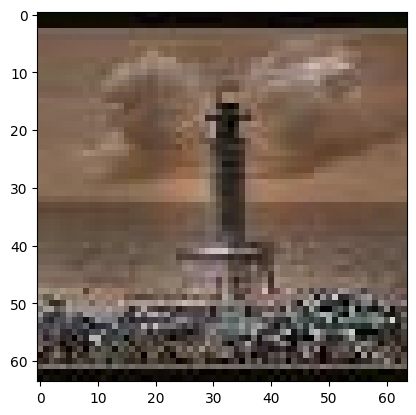

In [218]:
plt.imshow(cv2.cvtColor(np.dstack((L, y_true)), cv2.COLOR_Lab2BGR))

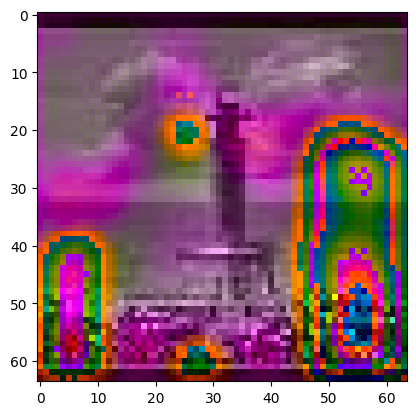

In [219]:
plt.imshow(cv2.cvtColor(np.dstack((L, y_pred)), cv2.COLOR_Lab2BGR))

In [216]:
custom_loss()

TypeError: ignored

In [153]:
y_true[20:-20, 20:-20, :] - y_pred[20:-20, 20:-20, :]

array([[[ 12,  20],
        [ 16,  15],
        [ 13,  20],
        ...,
        [ 16,  35],
        [  8,  27],
        [ 15,  33]],

       [[ 12,  19],
        [ 16,  20],
        [ 18,  23],
        ...,
        [ 26,  31],
        [ 15,  31],
        [ 24,  36]],

       [[ 12,  25],
        [ 17,  24],
        [ 21,  27],
        ...,
        [ 22,  29],
        [ 15,  27],
        [ 24,  37]],

       ...,

       [[251,  34],
        [  0,  37],
        [251,  37],
        ...,
        [249,  37],
        [247,  33],
        [249,  36]],

       [[252,  40],
        [255,  41],
        [250,  37],
        ...,
        [244,  39],
        [245,  35],
        [250,  37]],

       [[251,  35],
        [255,  37],
        [254,  37],
        ...,
        [250,  35],
        [248,  33],
        [249,  31]]], dtype=uint8)

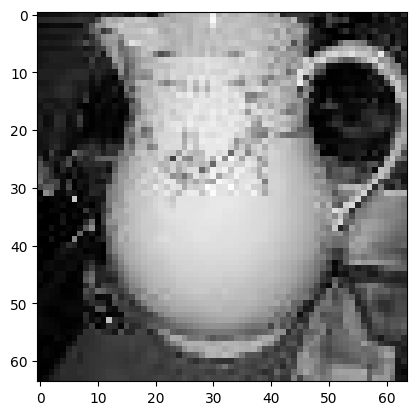

In [51]:
plt.imshow(X_test[2], cmap='gray')

In [ ]:
plt.imshow(a[1], cmap='br')

In [ ]:
l[0, :, :, 0]

In [ ]:
g[0]

In [53]:
y_pred

array([[[0.4840726 , 0.48348218],
        [0.46587878, 0.47419673],
        [0.4531484 , 0.46444967],
        ...,
        [0.47091112, 0.47296947],
        [0.4699508 , 0.45838037],
        [0.43330368, 0.50072324]],

       [[0.48270696, 0.47645363],
        [0.4736697 , 0.4788678 ],
        [0.45222008, 0.4686357 ],
        ...,
        [0.475108  , 0.47041467],
        [0.47957355, 0.5076219 ],
        [0.46840465, 0.48900187]],

       [[0.48244476, 0.47630462],
        [0.482964  , 0.49576497],
        [0.47021168, 0.4972063 ],
        ...,
        [0.4695856 , 0.49615568],
        [0.42839444, 0.47373438],
        [0.46607068, 0.49155942]],

       ...,

       [[0.47038853, 0.47954008],
        [0.46581525, 0.49627095],
        [0.46452576, 0.48564804],
        ...,
        [0.4813689 , 0.4764354 ],
        [0.4572456 , 0.49622464],
        [0.46422702, 0.48534703]],

       [[0.50254744, 0.50798535],
        [0.4776438 , 0.48565993],
        [0.47266674, 0.48929384],
        .

In [54]:
y_test[2]

array([[[ 12, 126, 128],
        [ 12, 126, 128],
        [ 14, 124, 130],
        ...,
        [ 12, 128, 136],
        [  9, 128, 133],
        [ 35, 128, 143]],

       [[ 31, 125, 129],
        [ 33, 124, 129],
        [ 34, 124, 130],
        ...,
        [ 36, 128, 141],
        [ 17, 128, 138],
        [ 12, 130, 135]],

       [[  6, 126, 130],
        [  7, 126, 130],
        [  9, 126, 130],
        ...,
        [ 24, 128, 139],
        [ 12, 128, 136],
        [ 26, 126, 141]],

       ...,

       [[  1, 126, 129],
        [  1, 126, 129],
        [  3, 126, 129],
        ...,
        [109, 128, 139],
        [ 15, 128, 136],
        [ 16, 128, 136]],

       [[  1, 126, 129],
        [  2, 126, 129],
        [ 11, 124, 129],
        ...,
        [103, 129, 140],
        [ 15, 130, 136],
        [  6, 130, 131]],

       [[  2, 126, 129],
        [  9, 126, 128],
        [ 23, 126, 128],
        ...,
        [ 89, 130, 141],
        [ 19, 130, 139],
        [ 16, 130, 137]]